In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img


%matplotlib inline

## Reading in X_train_array, X_test_array, y_train, y_test and df_comb

In [2]:
import h5py

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
with h5py.File('./datasets/X_train_array.h5', 'r') as hf:
    X_train_array = hf['X_train_array'][:]

In [4]:
with h5py.File('./datasets/X_test_array.h5', 'r') as hf:
    X_test_array = hf['X_test_array'][:]

In [5]:
# reading in y_train as a DataFrame
y_train = pd.read_csv('./datasets/y_train.csv')

In [6]:
# reading in y_test as a DataFrame
y_test = pd.read_csv('./datasets/y_test.csv')

In [7]:
# reading in df_comb as a DataFrame
df_comb = pd.read_csv('./datasets/df_comb.csv')

In [8]:
X_train_array[0][128][128]

array([0.91764706, 0.79607843, 0.61176471])

In [9]:
y_train.head()

,modified
0,0
1,1
2,0
3,0
4,0


## Sample Photo From X_train

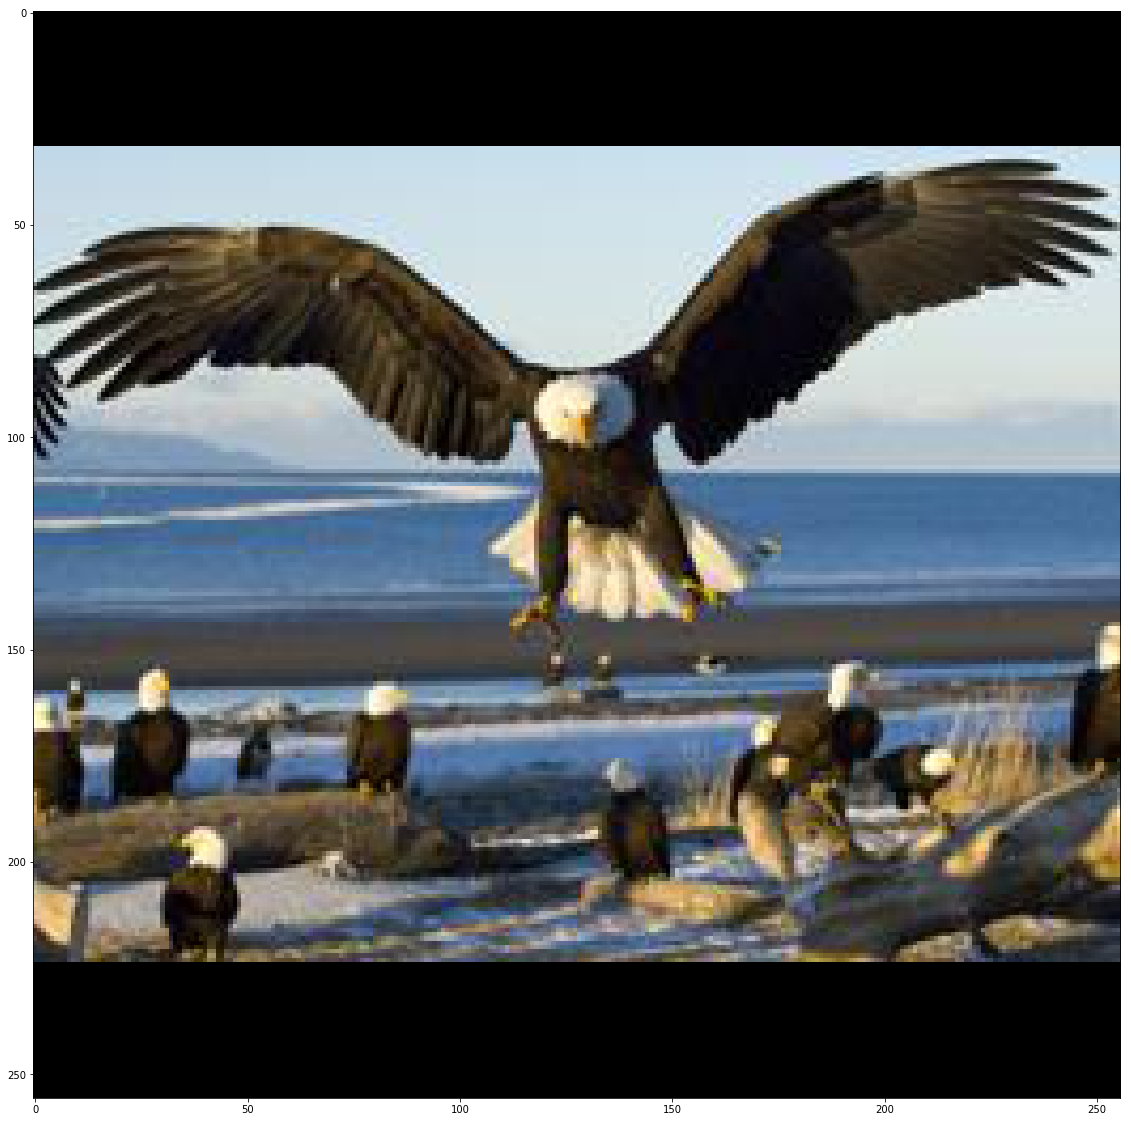

In [10]:
plt.figure(figsize = (30,20))
plt.imshow(X_train_array[0])
plt.show()

## Applying Template CNN Treatment

In [11]:
# !pip install keras
# !pip install tensorflow

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.utils import np_utils

from keras.utils import Sequence

from sklearn.model_selection import train_test_split


Using TensorFlow backend.


## Loading in Previously Trained Model and Weights

In [12]:
from keras.models import model_from_json


In [13]:
# load json and create model
json_file = open("./models/model_bootstrap_200_epochs_50_filter_3by3.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("./models/model_bootstrap_200_epochs_50_filter_3by3.h5")
print("Loaded model from disk")

Loaded model from disk


In [14]:
model = loaded_model

In [15]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 246016)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                7872544   
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)               

## Visualise Filters (first 2 filters of 3 channels)

In [17]:

# summarize filters in each convolutional layer
# from keras.applications.vgg16 import VGG16
from matplotlib import pyplot

# load the model
#model = VGG16()

# summarize filter shapes
for layer in model.layers:
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # get filter weights
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)

conv2d_1 (3, 3, 3, 32)
conv2d_2 (3, 3, 32, 64)


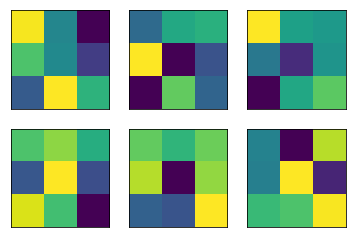

In [40]:

# retrieve weights from the second hidden layer
filters, biases = model.layers[0].get_weights()

# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

# plot first few filters
n_filters, ix = 2, 1
for i in range(n_filters):
	# get the filter
	f = filters[:, :, :, i]
	# plot each channel separately
	for j in range(3):
		# specify subplot and turn of axis
		ax = pyplot.subplot(n_filters, 3, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(f[:, :, j], )
		ix += 1
# show the figure
pyplot.show()

## Visualise Feature Maps

In [19]:
# summarize feature map shapes
for i in range(len(model.layers)):
	layer = model.layers[i]
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# summarize output shape
	print(i, layer.name, layer.output.shape)

0 conv2d_1 (None, 254, 254, 32)
2 conv2d_2 (None, 125, 125, 64)


Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 254, 254, 32)      896       
Total params: 896
Trainable params: 896
Non-trainable params: 0
_________________________________________________________________


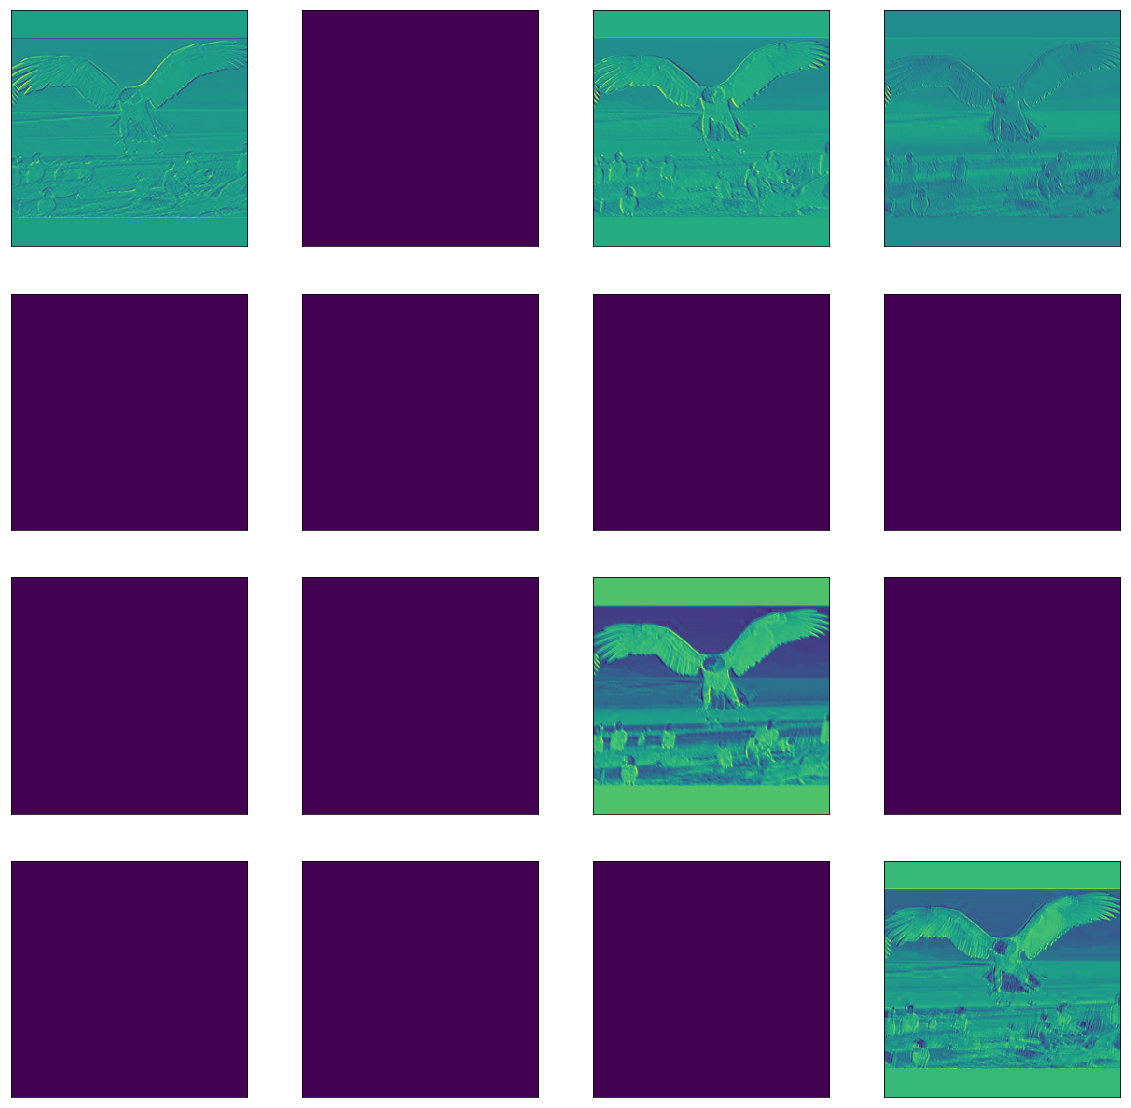

In [41]:
# plot feature map of first conv layer for given image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims

import PIL
from PIL import Image

# load the model
#model = VGG16()
# redefine model to output right after the first hidden layer
model_2 = Model(inputs=model.inputs, outputs=model.layers[0].output)
model_2.summary()

# convert the image to an array
img = X_train_array[0]

# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)

# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model_2.predict(img)
# plot all first 16 maps in an 3x3 square
square = 4
ix = 1

f = plt.figure(figsize=(20,20))

for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        
        ax = pyplot.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(feature_maps[0, :, :, ix-1])
        ix += 1
# show the figure
pyplot.show()